<a href="https://colab.research.google.com/github/sfnesbit/Wildfire-Risk-Assessment/blob/main/Google_Earth_Engine_MODOIS_Image_Downloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download MODIS product bands from Google Earth Engine

### **Sean Nesbit**

### **Environment Setup**

In [ ]:
# Cloud authentication.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
#Start Eath Engine w/ minimal authentication popups
try:
    ee.Initialize()
    print("Earth Engine initilized successfully!")
except ee.EEException as e:
    try:
        ee.Authenticate()
        ee.Initialize()
    except ee.EEException as e2:
        print("Earth Engine could not be initialized!")
        exit()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Y4UYGIFWoEnieQyvgfezFdinbwKQlSUlXvTXh2xOBuc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWh8lPDAcsJe49utygZ6g-ESAUBfH3HqhET5Uu0lFnlILiQ_PJDgRQc

Successfully saved authorization token.


In [ ]:
from IPython.core.display import display, HTML
import os
import cv2   
import ast
import json
import folium
import random
import imageio
import requests
import functools
import numpy as np
import tensorflow as tf
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from io import BytesIO
directory = "/content/drive/MyDrive/Thesis"

### **Select MODIS Products & Bands**

In [ ]:
# Products and relevant bands selected

products = {}
#products['surfaceRealTime'] = {'code': "LANDSAT/LC08/C01/T1_RT", 'bands': ['B4', 'B3', 'B2'], 'type': 'imageCollection'}

# Land Surface Temp Daily 1km           https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1
#products["lstDaily1km"] = {'code': "MODIS/006/MOD11A1", 'bands': ['LST_Day_1km'], 'min': 7500, 'max': 65535, 'type': 'imageCollection'}

# Land Surface Temp 8Day 1km            https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A2
products["lst8Day1km"] = {'code': "MODIS/006/MOD11A2", 'bands': ['LST_Day_1km'], 'min': 7500, 'max': 65535, 'type': 'imageCollection'}

# Leaf Area Index 4Day 500m             https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD15A3H
products["leafAreaIndex4Day500m"] = {'code': "MODIS/006/MCD15A3H", 'bands': ['Fpar', 'Lai'], 'min': 0, 'max': 100, 'type': 'imageCollection'}

# Gross Primary Productivity 8Day 500m  https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A2H
products["productivity8Day500m"] = {'code': "MODIS/006/MOD17A2H", 'bands': ['Gpp'], 'min': 0, 'max': 3000, 'type': 'imageCollection'}

# Evapotranspiration 8Day 500m          https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
products["evapo8Day500m"] = {'code': "MODIS/006/MOD16A2", 'bands': ['ET', 'LE', 'PET', 'PLE'], 'min': -3276, 'max': 3270, 'type': 'imageCollection'}

# Vegetation Index 16Day 250m           https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1
products["ndvi16Day250m"] = {'code': "MODIS/006/MOD13Q1", 'bands': ['EVI'], 'min': -2000, 'max': 10000, 'type': 'imageCollection'}

# Land Cover type 500m                  https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1
products["landCover500m"] = {'code': "MODIS/006/MCD12Q1", 'bands': ['LC_Type1'], 'min': 1, 'max': 17, 'type': 'imageCollection'}

# Atmosphere monthly 1degree            https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD08_M3
#bands["atmosphere1Mo1deg"] = {'code': "MODIS/061/MOD08_M3", 'bands': [], 'min': None, 'max': None, 'type': 'imageCollection'}

# Vapor 6hr 2.5deg                      https://developers.google.com/earth-engine/datasets/catalog/NCEP_RE_surface_wv#description
products["vapor6Hr2deg"] = {'code': "NCEP_RE/surface_wv", 'bands': ['pr_wtr'], 'min': -8.2, 'max': 89.8, 'type': 'imageCollection'}

# Elevation 90m                         https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4#bands
products["elevation90m"] = {'code': "CGIAR/SRTM90_V4", 'bands': ['elevation'], 'min': -444, 'max': 8806, 'type': 'image'}




In [ ]:
# [(sw_lon, sw_lat), (ne_lon, ne_lat)]
def rectangleGeoJSON(coords):
  sw_lon = coords[0][0]
  sw_lat = coords[0][1]
  ne_lon = coords[1][0]
  ne_lat = coords[1][1]
  return ee.Geometry.Rectangle([[sw_lon, sw_lat], [ne_lon, ne_lat]])

### **Folium Helper Functions**

In [ ]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)

        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)

        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))

folium.Map.add_ee_layer = add_ee_layer

### **Folium Map Example With All Products & Bands**

In [ ]:
# Start map in San Francisco
productMap = folium.Map(location=[37.5010, -122.1899], zoom_start=10)

# Combine layers onto folium map
for product in products.items():
  img = None

  # Correct call to GEE
  if product[1]['type'] == 'imageCollection':
    if product[0] == "ndvi16Day250m": # Guarantee found in 16 day range
      img = ee.ImageCollection(product[1]['code']).filterDate("2020-07-01", "2020-07-17")
    elif product[0] == "landCover500m": # Find annualized LandCover type
      img = ee.ImageCollection(product[1]['code']).mean()
    else:
      img = ee.ImageCollection(product[1]['code']).filterDate("2020-07-01", "2020-07-08")
  elif product[1]['type'] == 'image':
    img = ee.Image(product[1]['code'])

  # RGB instead of grayscale
  if product[0] == 'surfaceRealTime':
    image_viz_params = {
      'bands': ['B4', 'B3', 'B2'],
      'min': 0,
      'max': 30000
    }
    # Add to the map
    productMap.add_ee_layer(img, image_viz_params, 'surfaceRealTime')
    continue

  # Make grayscale map for each band
  for band in product[1]['bands']:
    image_viz_params = {
        'bands': band,
        'min': product[1]['min'],
        'max': product[1]['max']
    }
    # Add the band to the map
    productMap.add_ee_layer(img, image_viz_params, '{} - {}'.format(product[0], band))

# Display 
folium.LayerControl().add_to(productMap)
display(productMap)


In [ ]:
productMap.save("MODISMap.html")

# Create download metadata
BEFORE: Upload firedata json files to "burn/" folder

In [ ]:
# Read land tiles
def getLandTiles(filename):
    landTiles = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            landTiles.append(ast.literal_eval(line))
    return landTiles
  

# 2D dictionary like dict[lon][lat]
def makeFireDictionary(landTiles):
    fireData = {}
    for tile in landTiles:
        longitude = str(tile[0][0])
        latitude  = str(tile[0][1])
        if longitude not in fireData:
            fireData[longitude] = {}
        fireData[longitude][latitude] = []
    return fireData


# Burned dictionary
def getAllBurnDates(tiles, fireDataDirectory):
    # Get JSON data files sorted from oldest to newest data
    files = sorted(os.listdir(fireDataDirectory))

    # Combine all into dictionary
    data = makeFireDictionary(tiles)
    for file in files:
        with open(os.path.join(fireDataDirectory,file)) as f:
            temp = json.load(f)
            # Delete 'date' field in JSON
            if 'dates' in temp: del temp['dates']
            # For each tile, append burnDate if the tile burned
            for lon in temp.keys():
                for lat, burnDate in temp[lon].items():
                    if burnDate is not None:
                        data[lon][lat].append(burnDate)
    return data


# Write list of points to file
def writeTrainingPointsFile(points, filename):
  with open(filename, 'w') as file:
    for point in points:
      file.write(f'({point[0][0]}, {point[0][1]}), "{point[1]}", {point[2]}\n')


# Read list of points from file
def readTrainingPointsFile(filename):
  points = []
  if os.path.isfile(filename):
    with open(filename, 'r') as file:
      for line in file.readlines():
        points.append(ast.literal_eval(line))
  return points

### Retrieve tiles, build directories

In [ ]:
tiles = getLandTiles(os.path.join(directory, "tiles/landTiles.txt"))
print(len(tiles), 'Land Tiles Found!')

### Build dictionary of fire data

In [ ]:
# Retreive burn instances from every date range
fireDataDict = getAllBurnDates(tiles, os.path.join(directory, "burn"))

# Sanity check that the burn dictionary contains fire data and correct num tiles
burned = 0
tileCount = 0
for lon in fireDataDict.keys():
  for lat in fireDataDict[lon].keys():
    burned += len(fireDataDict[lon][lat])
    tileCount += 1
print(f'{burned} burn instances found across {tileCount} tiles')

9319 burn instances found across 6910 tiles


### Calculate dates found

In [ ]:
filenames = os.listdir(os.path.join(directory, 'burn'))
dates = []
# Find each fireData.json file and strip off date from filename
for file in filenames:
  # Break off ".json", split on hyphen, gets Year, Month, Day, joins with hyphen to datelike string
  date = "-".join(file[:-5].split("-")[1:])
  dates.append(date)
print(f'{len(dates)} date ranges found')

108 date ranges found


In [ ]:
bandCount = 12
for product in products.values():
  bandCount += len(product['bands'])

tileCount = len(tileCount)
dateCount = len(dates)
trainingPoints = tileCount * dateCount
totalImages = trainingPoints
imageSize = 64*64*bandCount
totalSizeBytes = totalImages*imageSize
totalSizeGB = totalSizeBytes/(1024*1024*1024)

print(f'With {tileCount:,} tiles and {dateCount:,} dates, we can expect {trainingPoints:,} images (training points)')
print(f'Each image will have {bandCount} channels, resulting in {imageSize*bandCount:,} bytes per image')
print(f'This yields a total dataset size of {totalSizeBytes:,} bytes or ~{totalSizeGB:0.2f} GB')
print(f'I will sample this dataset to roughly 1/3 of the original size, or ~{(totalSizeGB/3):0.2f} GB')

With 6,910 tiles and 108 dates, we can expect 746,280 training points
Each training point will have 12 images, resulting in 8,955,360 images
Each image is approximately 4096 bytes, yielding a total dataset size of 36,681,154,560 bytes or ~34.16 GB
I will sample this dataset to roughly 1/3 of the original size, or ~11.39 GB


### Splitting the dataset to 1/3 the size

In [ ]:
reduction = 1/3
trainingPoints = []

for date in dates:
  for lon in fireDataDict.keys():
    for lat in fireDataDict[lon].keys():
      burned = date in fireDataDict[str(lon)][str(lat)] 
      trainingPoint = ([lon,lat], date, burned)
      trainingPoints.append(trainingPoint)

burned = [point for point in trainingPoints if point[2]]
unburned = [point for point in trainingPoints if not point[2]]

print(f'{len(trainingPoints)} Training Points found')
print(f'\t{len(burned)} burned\n\t{len(unburned)} unburned')
print('Reudcing training points...')

# Shuffle list
random.seed(datetime.now())
random.shuffle(trainingPoints)
# Subset array
reduceToIndex = int(reduction * len(trainingPoints))
reducedTrainingPoints = trainingPoints[:reduceToIndex]

burned = [point for point in reducedTrainingPoints if point[2]]
unburned = [point for point in reducedTrainingPoints if not point[2]]

print(f'{len(reducedTrainingPoints)} Training Points in reduced set')
print(f'\t{len(burned)} burned\n\t{len(unburned)} unburned')

### Write reduced set to file

In [ ]:
filename = os.path.join(directory, "tiles/tilesToDownload.txt")
writeTrainingPointsFile(reducedTrainingPoints, filename)

Wrote data to /content/drive/MyDrive/Thesis/tiles/tilesToDownload.txt


# Read reduced set from file

In [ ]:
filename = os.path.join(directory, "tiles/tilesToDownload.txt")
reducedTrainingPoints = readTrainingPointsFile(filename)

print(len(reducedTrainingPoints), "Training Points found")

248760 Training Points found


Get tiles that are burned (to rebalance dataset manually)

In [ ]:
burnedTiles = list(filter(lambda x: x[2] == True, reducedTrainingPoints))
print(len(burnedTiles))

3155


# Download MODIS Data


## Helper Functions

In [ ]:
def get_modis_thumbnail_urls(coords, date, burned, products, side=0.1):
  # Define coordinates
  sw_lon = coords[0]
  sw_lat = coords[1]
  ne_lon = sw_lon + side
  ne_lat = sw_lat + side
  area = rectangleGeoJSON([(sw_lon, sw_lat),(ne_lon, ne_lat)])

  # Define dates
  date = datetime.strptime(date, "%Y-%m-%d")
  datePrior = (date - timedelta(days=17)).strftime("%Y-%m-%d")
  date = date.strftime("%Y-%m-%d")

  # Define output
  imgURLs = []

  # List of all created bands
  megaImage = ee.Image()

  # Save bands to list of single-band images
  for product in products.values():
    # For any Non-Collection images
    if product['type'] == "image":
      i = ee.Image(product['code'])
    
    # For ImageCollections
    elif product['type'] == "imageCollection":
      # Find NDVI/EVI event in 16 day window
      if product['code'] == "MODIS/006/MOD13Q1":
        i = ee.ImageCollection(product['code']).filterDate(datePrior, date).max()
      # Find land type annualized
      elif product['code'] == "MODIS/006/MCD12Q1": 
        i = ee.ImageCollection(product['code']).max()
      # Regular products
      else:
        i = ee.ImageCollection(product['code']).filterDate(datePrior, date).median()
    
    # Build Image per band
    for band in product['bands']:
      megaImage = megaImage.addBands(i.select(band))
  
  # Extract band names
  bandNames = megaImage.bandNames().getInfo()
  for band in bandNames:
    # Skip default band
    if band != 'constant':
      # Find the min/max values
      for product in products.values():
        if band in product['bands']:
          min = product['min']
          max = product['max']
      # Add to URL list
      imgURLs.append(megaImage.select(band).getThumbURL({
        "region": area,
        "dimensions": "64x64",
        "format": "png",
        "min": min, "max": max
      }))
  return imgURLs

# Convert LC Type to 17 binary layers
def binarize_LC_Type(img):
  #select the LC_Type layer
  cover_img = img[:,:,9]
  # create the 17 cover type binary layers
  binary = np.zeros((64,64,17)).astype('uint8') 
  #iterate over the LC_Type img
  for idx, x in enumerate(cover_img):
      for idy, y in enumerate(cover_img[idx]):
          # which binary layer to select
          cover_layer = int(np.round(y/16)) #convert back to LC_type 1-17
          # set that binary layer and X,Y coord as 1
          binary[idx,idy,cover_layer]=1

  # add binary layers to end of climate image
  new_img = np.append(img, binary, 2)
    
  # remove old LC_Type1 layer
  return np.array(np.delete(new_img,9,2))
  

# Download images from given URLs, convert to grayscale if needed
def URLs_to_numpy(urls):
  imgs = []
  # For each URL
  for url in urls:
    # Download, convert to numpy
    res = requests.get(url)
    img = imageio.imread(BytesIO(res.content))

    # Grayscale there is more than 1 color band
    if len(img.shape) > 2:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs.append(img)

  # Stack into 12 channels (64, 64, 12) 
  imgs = np.dstack(np.array(imgs))

  # convert LC_Type1 to binary layers (64,64,32)
  imgs = binarize_LC_type(imgs)
  return imgs




# Save imgs according to metadata
def save_numpy_array(img, coords, date, burned, directory="/content/drive/MyDrive/Thesis/climate/"):
  burned = "burned" if burned else "unburned"
  filename = f'{date}_{coords[0]}_{coords[1]}.npy'
  filepath = os.path.join(directory, burned, filename)
  np.save(filepath, img)
  print("\t",filepath)

## Example download images to Numpy








In [ ]:
# Define bounding geometry (lake oroville)
coords = (-121.5, 39.6)

# Did the area burn in this timeframe? To be computed elsewhere, for file naming
burned = False

# Date
date = "2015-07-29"

# Start
urls = get_modis_thumbnail_urls(coords, date, burned, products)
imgs = URLs_to_numpy(urls)
print(imgs.shape)

['constant', 'LST_Day_1km', 'Fpar', 'Lai', 'Gpp', 'ET', 'LE', 'PET', 'PLE', 'EVI', 'LC_Type1', 'pr_wtr', 'elevation']
(64, 64, 12)


(64, 64)


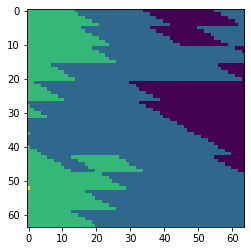

(64, 64)


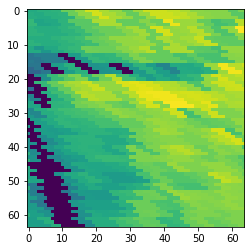

(64, 64)


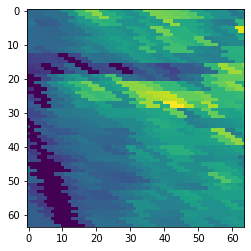

(64, 64)


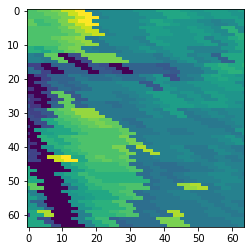

(64, 64)


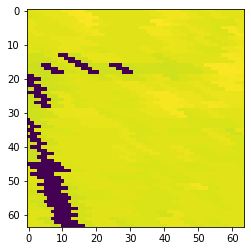

(64, 64)


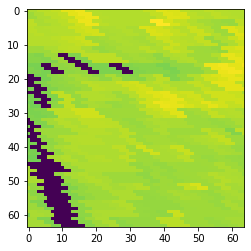

(64, 64)


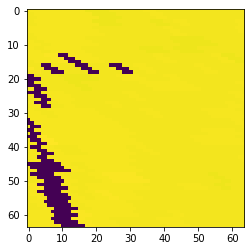

(64, 64)


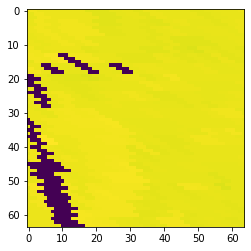

(64, 64)


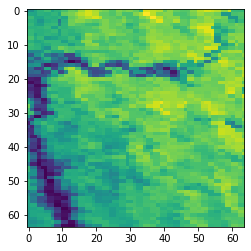

(64, 64)


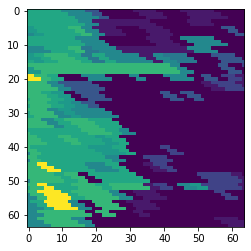

(64, 64)


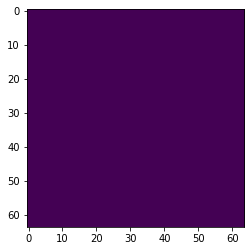

(64, 64)


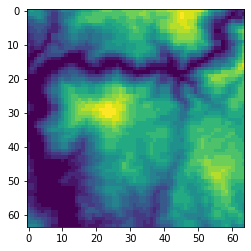

In [ ]:
# Iterate over channels
for i in range(imgs.shape[2]):
  print(imgs[:,:,i].shape)
  plt.imshow(imgs[:,:,i])
  plt.show()

## Download all images

In [ ]:
batchSize = 50
batch = []
completedFile = "/content/drive/MyDrive/Thesis/tiles/completed.txt"
completed = readTrainingPointsFile(completedFile)
totalLen = len(burnedTiles)

for idx, trainingPoint in enumerate(burnedTiles):

  # Skip previously completed points
  if trainingPoint in completed:
    continue

  # Add current training point to batch
  batch.append(trainingPoint)

  # Run the batch
  if len(batch) == batchSize:
    print(f"{idx+1}/{totalLen} -- Batching {batchSize}")
    # Kick off every tfrecord download
    for point in batch:
      coords = point[0]
      date = point[1]
      burned = point[2]
      urls = get_modis_thumbnail_urls(coords, date, burned, products)
      img = URLs_to_numpy(urls)
      save_numpy_array(img, coords, date, burned)

    # Write training points to completed file
    completed.extend(batch)
    writeTrainingPointsFile(completed, completedFile)
    batch = []



410/3155 -- Batching 50
	 /content/drive/MyDrive/Thesis/climate/burned/2016-08-19_-120.7_36.1.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2015-10-21_-122.7_40.6.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2018-08-05_-122.3_40.9.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2015-08-26_-118.5_36.4.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2015-07-29_-122.7_38.8.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2018-08-05_-117.0_33.0.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2018-10-21_-121.2_37.6.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2017-09-16_-118.7_36.0.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2017-09-02_-119.2_36.4.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2018-09-16_-114.8_40.0.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2018-08-05_-123.6_41.8.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2015-07-29_-122.3_38.8.npy
	 /content/drive/MyDrive/Thesis/climate/burned/2020-10-07_-121.3_39.8.npy
	 /content/dri

### Display images

301


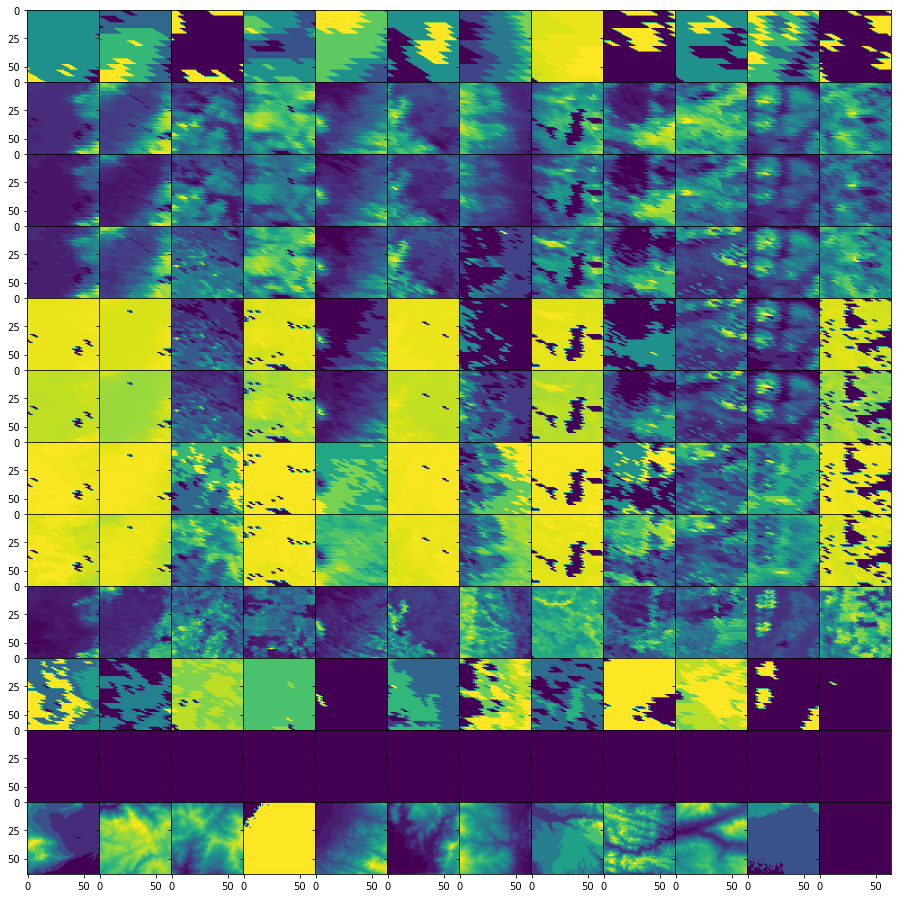

In [ ]:
ncol = 12
nrow = 12
burnedDir = "/content/drive/MyDrive/Thesis/climate/burned"
burnedNpys = os.listdir(burnedDir)
print(len(burnedNpys))
random.shuffle(burnedNpys)
toShow = [np.load(os.path.join(burnedDir, file)) for file in burnedNpys[:ncol]]

fig, axs = plt.subplots(nrow, ncol, 
    gridspec_kw=dict(
      wspace=0.0, hspace=0.0,
      top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1), 
      left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)
    ),
    figsize=(ncol + 1, nrow + 1), sharey='row', sharex='col')

for i in range(nrow):
  for j in range(ncol):
    axs[i, j].imshow(toShow[j][:,:,i])

In [ ]:
print('test')

In [ ]:
"whoot"